# ["Наивный" Байесовский метод - Naive Bayes](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9_%D0%B1%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)

Данный метод используется в основном для решения задачи классификации.

Существуют попытки использовать данный метод для регресии, например [Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression) но такие методы используются нечасто.

## Математические основы метода

## [Реализация наивного Байесовского классификатора в библиотеке scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html)

Данный метод реализован в библиотеке scikit-learn с использованием нескольких классов. В основом они различаются тем, на какое распределение входных данных они рассчитаны.

Поскольку наивный Байесовский классификатор может использоваться на очень больших выборках, которые не помещаются в оперативную память (в частности для классификации текстовых данных), то у рассматриваемых классов кроме метода fit также реализован метод partial_fit, позволяющий поочередно  обучать классификатор на отдельных фрагментах выборки.

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Используем датасет iris с двумя первыми признаками
iris = load_iris()
iris_X = iris.data[:, :2]
iris_y = iris.target

In [3]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

### Gaussian Naive Bayes

В этом случае предполагается что значения анализируемых признаков распределены [нормально.](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) Функция плотности вероятности может быть записана следующим образом:

$$ P(x_i | y) = \frac{1}{\sqrt{2 \pi \sigma_y^2}} \cdot exp \Big( -\frac{(x_i - \mu_y)^2}{2 \sigma_y^2} \Big) $$

Значения $\sigma_y$ и $\mu_y$ оцениваются с помощью принципа максимального правдоподобия.

Данный метод реализуется с помощью класса [GaussianNB.](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

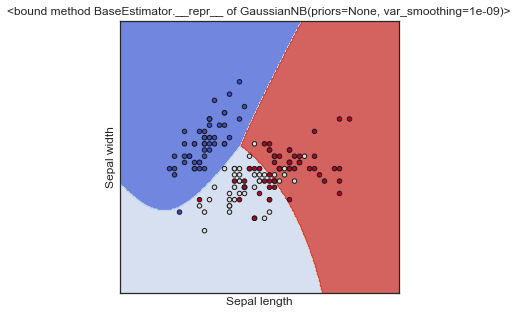

In [4]:
plot_cl(GaussianNB())

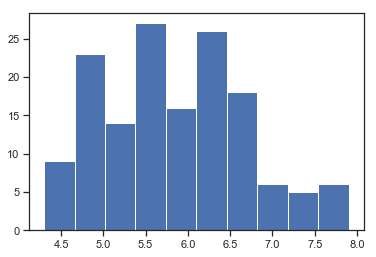

In [5]:
# Проверим как распределены признаки
plt.hist(iris_X[:, 0])
plt.show()

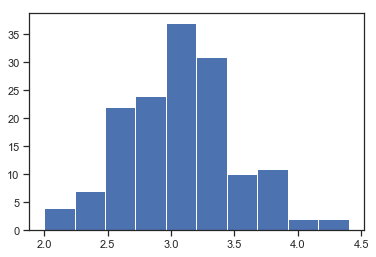

In [6]:
plt.hist(iris_X[:, 1])
plt.show()

Распределение признаков заметно отличается от нормального. Поэтому при классификации заметны ошибки.

Попробуем искусственно сгенерировать признаки на основе нормального распределения.

In [7]:
def test_normal():
    global iris_X
    
    feature_1 = np.random.normal(size=150)
    plt.hist(feature_1)
    plt.show()
    
    feature_2 = np.random.normal(size=150)
    plt.hist(feature_2)
    plt.show()
    
    iris_X1 = np.column_stack((feature_1, feature_2))
    iris_X = iris_X1
    plot_cl(GaussianNB())

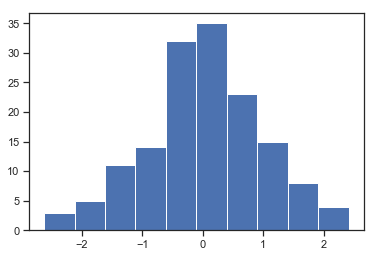

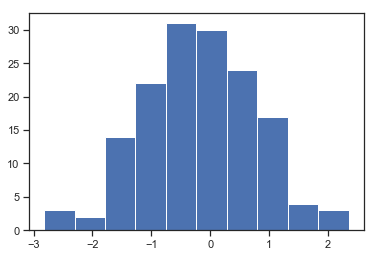

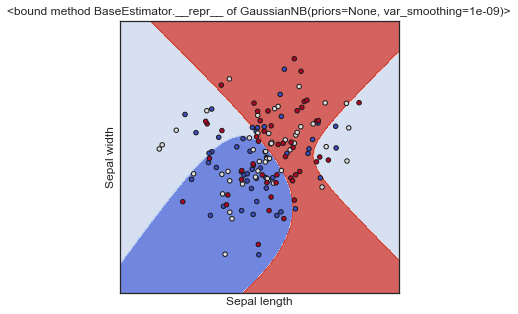

In [8]:
test_normal()

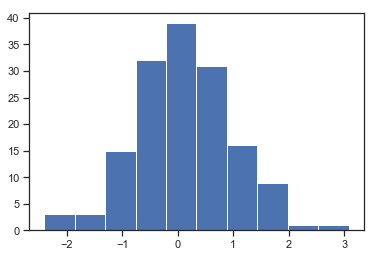

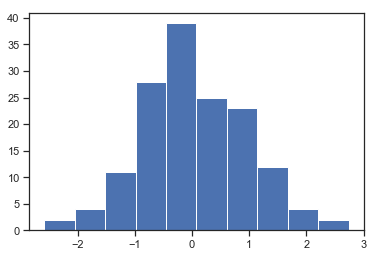

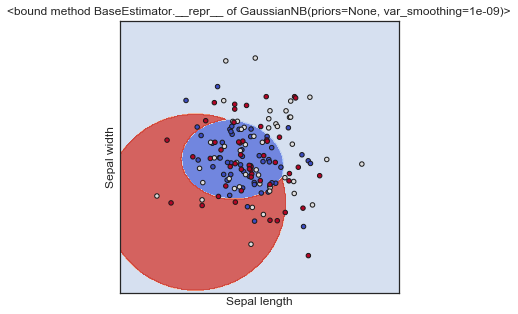

In [9]:
test_normal()

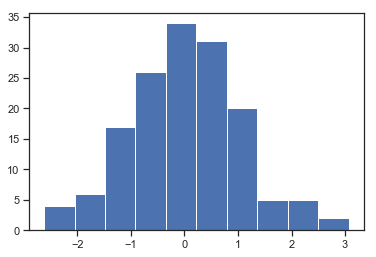

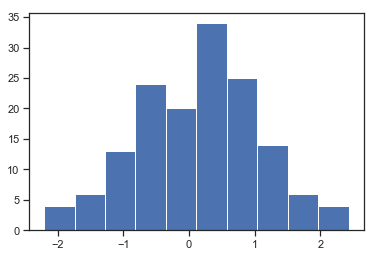

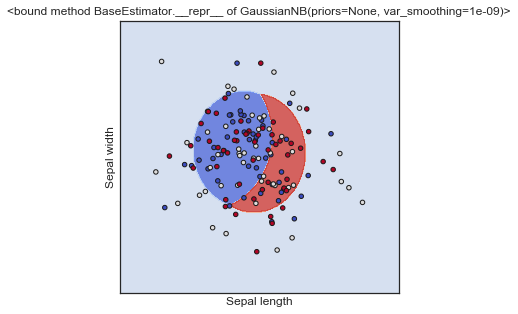

In [10]:
test_normal()

### Multinomial Naive Bayes (MNB)

Данный метод используется в основном для классификации текстов.

Реализует алгоритм "наивного" Байеса для [мультиномиального распределения.](https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BD%D0%BE%D0%BC%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

Предполагается, что входными данными является результат работы CountVectorizer. Отмечается, что в случае использования TfidfVectorizer метод также работает хорошо.

Распределение параметризуется вектором $ \theta_y = (\theta_{y1}, \dots, \theta_{yn}) $ для каждого класса $y$, где $n$ - количество признаков (для случая классификации текстов это размер словаря); $\theta_{yi}$ - вероятность $P(x_i | y)$ того что признак $i$ присутствует в текущем примере (строке данных), принадлежащем к классу $y$. 

Параметры $ \theta_y $ оцениваются с использованием [аддитивного сглаживания:](https://en.wikipedia.org/wiki/Additive_smoothing)

$$ \hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_{y} + \alpha n}  $$

где:

- $ N_{yi} = \sum\limits_{x \in T} x_i $ - количество раз, которое признак $i$ встретился в примерах класса $y$ обучающей выборки $T$;
- $ N_{y} = \sum\limits_{i=1}^{n} N_{yi} $ - суммарное количество всех признаков для класса $y$.

Значение гиперпараметра сглаживания $\alpha \geqslant 0$ позволяет избежать использования нулевых  вероятностей. Вариант сглаживания при $\alpha=1$ называют Лапласовым сглаживанием (Laplace smoothing), а вариант сглаживания при $\alpha<1$ называют сглаживанием Лидстоуна (Lidstone smoothing).

Данный метод реализуется с помощью класса [MultinomialNB.](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

### Complement Naive Bayes (CNB)

Является развитием метода Multinomial Naive Bayes (MNB) и особенно хорошо подходит для наборов данных с сильным дисбалансом классов.

CNB использует статистику из дополнения каждого класса для вычисления весов модели. Изобретатели CNB эмпирически показали, что оценки параметров для CNB более стабильны, чем для MNB. Как правило, CNB превосходит MNB (часто со значительным отрывом) в задачах классификации текста. 

Порядок расчета весов выглядит следующим образом:

$$ \hat{\theta}_{ci} = \frac{\alpha_i + \sum\limits_{j:y_j \ne c} d_{ij}}{\alpha + \sum\limits_{j:y_j \ne c} \sum\limits_{k} d_{kj} } $$

$$ w_{ci} = log \big( \hat{\theta}_{ci} \big) $$

$$ w_{ci} = \frac{w_{ci}}{\sum\limits_{j} |w_{ci}|} $$

Суммирование выполняется по всем документам $j$ не входящим в класс $c$. Значение $d_{ij}$ формируется с использованием CountVectorizer или TfidfVectorizer для термина $i$ в документе $j$. $\alpha_i$ - гиперпараметр сглаживания (такой же как и для MNB), $ \alpha = \sum\limits_{i} \alpha_i$.

Для классификации используется следующая формула:

$$ \hat{c} = arg \big(  min_c \sum\limits_{i} t_i w_{ci}  \big) $$  

где $ t = (t_1, \dots , t_n) $ - тестовый документ, $ t_i $ - количество вхождений слова $i$.

Данный метод реализуется с помощью класса [ComplementNB.](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB)

### Bernoulli Naive Bayes

Данный метод реализует алгоритм классификации для данных, к которым применимо многомерное распределение Бернулли. Многомерное распределение означает, что набор данных может содержать несколько признаков, но все они являются двоичными. Таким образом, весь датасет должен состоять из двоичных (бинарных) признаков.

При использовании параметра binarize бинаризация признаков производится в автоматическом режиме. Но данный режим является тривиальным, так как задает только порог для бинаризации.   

Функция плотности вероятности может быть записана следующим образом:

$$ P(x_i | y) = P(i | y)x_i + (1 - P(i | y))(1 - x_i) $$

Если метод Multinomial Naive Bayes просто игнорирует отсутствие признака, то Bernoulli Naive Bayes устанавлиявает явное "пенальти" за отсутствие признака.

Данный метод также можно использовать для классификации текстов. Но в этом случае нужно использовать частный случай CountVectorizer (с параметром binary=True), который не считает количество вхождений слов в текст, а устанавливает 1 в случае наличия слова в тексте или 0 в случае отсутствия слова. Определяется не количество вхождений слов в текст, а факт присутствия слова в тексте, в этом случае все признаки являются бинарными.

Отмечается, что данный метод относительно неплохо работает в случае коротких текстовых документов.

Данный метод реализуется с помощью класса [BernoulliNB.](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)

### Решение задачи анализа тональности текстов с использованием  Байесовских методов

In [11]:
imdb_df = pd.read_csv("data/imdb_labelled.txt", delimiter='\t', header=None, names=['text', 'value'])
imdb_df.head()

,text,value
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [12]:
X_train, X_test, y_train, y_test = train_test_split(imdb_df['text'], imdb_df['value'], test_size=0.5, random_state=1)

In [13]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [14]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(y_test, y_pred)

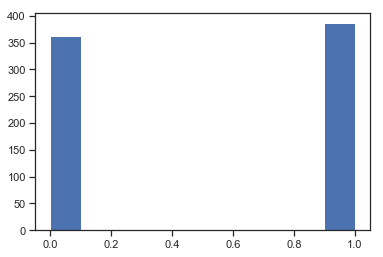

In [15]:
# В целевом признаке распределение классов относительно равномерное
plt.hist(imdb_df['value'])
plt.show()

In [16]:
# Классификация с использованием логистической регресии
sentiment(TfidfVectorizer(), LogisticRegression(C=5.0))

Метка 	 Accuracy
0 	 0.7964071856287425
1 	 0.6859903381642513


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
sentiment(CountVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 0.874251497005988
1 	 0.5217391304347826


In [18]:
sentiment(TfidfVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 0.9041916167664671
1 	 0.5603864734299517


In [19]:
sentiment(CountVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.874251497005988
1 	 0.5507246376811594


In [20]:
sentiment(TfidfVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.8622754491017964
1 	 0.6521739130434783


In [21]:
sentiment(CountVectorizer(binary=True), BernoulliNB())

Метка 	 Accuracy
0 	 0.9041916167664671
1 	 0.5362318840579711


Методы классификации текстов, основанные на "наивном" Байесе работают не хуже чем логистическая регрессия.

## Дополнительные источники

- [Описание метода на machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [6 простых шагов для освоения наивного байесовского алгоритма (с примером кода на Python)](http://datareview.info/article/6-prostyih-shagov-dlya-osvoeniya-naivnogo-bayesovskogo-algoritma-s-primerom-koda-na-python/)
- [Naive Bayes Classification With Sklearn](https://blog.sicara.com/naive-bayes-classifier-sklearn-python-example-tips-42d100429e44)
- [Implementing 3 Naive Bayes classifiers in scikit-learn](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/)
